# Calculating the TRM with Neural Networks

In this exercise we are going to code a Generic Neural Network with Backpropagation from Scratch, that is, we can vary number of layer and neurons as well as activation and loss functions

# Preamble

We are going to use numpy for linear algebra operations

In [298]:
import numpy as np

Pandas and scikit will be used for data loading and normalization

In [299]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

The following libraries will be used for ease of coding and IDE integration

In [300]:
from typing import Callable, Any, Protocol
from dataclasses import dataclass

# Activation and Error functions

We are going to define a base protocol (think of it as an implicit Interface) for differentiable functions, and we are going to define several activation functions and an error function following it

In [301]:
class DifferentiableFunction(Protocol):
   @classmethod
   def eval(cls,input: Any) -> Any:
      ...

   @classmethod
   def deriv(cls,input: Any)-> Any:
      ...

class TanH:
   @classmethod
   def eval(_cls, input):
      return np.tanh(input)
   @classmethod
   def deriv(_cls, input):
      f = _cls.eval(input)
      return 1 - f**2
   
class ReLU:
   @classmethod
   def eval(_cls, input):
      return input * (input > 0)
   @classmethod
   def deriv(_cls, input):
      return ((input >= 0))



class Sigmoid:
   @classmethod
   def eval(_cls, input):
      return 1/(1+np.exp(-input))
   @classmethod
   def deriv(_cls, input):
      sigma = _cls.eval(input)
      return sigma * (1- sigma) 

class QuadraticCost:
   @classmethod
   def eval(_cls,input):
      y_hat,y = input

      diff = y - y_hat 
      return np.matmul(np.rot90(diff,axes=(1,2)),diff).mean() / 2
   
   @classmethod
   def deriv(_cls,input):
      y_hat,y = input
      n_inputs,n_rows,should_be_1 = y.shape
      return (y_hat - y)/n_rows 

# Randomness

Seed here if you want to get reproducible results

In [302]:
rng = np.random.default_rng(seed=None)

In [303]:
@dataclass(frozen=True)
class LayerDescription:
   n_neurons: int
   act_fun: DifferentiableFunction

class LayerPass:
   def __init__(self, input: LayerDescription, output: LayerDescription):
      self.size = (output.n_neurons, input.n_neurons)

      self.weights = rng.uniform(
         low=-1,
         high=1,
         size= self.size
      )

      self.bias = rng.uniform(low=-1,high=1, size=(output.n_neurons,1))
      # self.bias = np.zeros((output.n_neurons,1))
      self.last_A = np.zeros((output.n_neurons,1))
      self.last_Z = np.zeros((output.n_neurons,1))

      self.func = input.act_fun
   
   def __str__(self) -> str:
      return "\n".join([f'{self.size[1]} -> {self.size[0]}',
              f'w=\n{self.weights}',
              f'b=\n{self.bias}',
              f'f={self.func}', ""])
   
   def forward(self, A):
      # print(f'{A=}')
      # print(f'{self.weights=}')
      # print(f'{self.bias=}')

      n_inputs = A.shape[1]

      Z = np.matmul(self.weights,A) + self.bias[np.newaxis,:,:]

      self.last_A = A 
      # print(f'{Z=}')
      new_A = self.func.eval(Z)
      # print(f'{A=}')
      self.last_Z = Z

      return new_A, Z

   def backward(self, W_delta_L_1, rate):
      delta_L_1 = W_delta_L_1 * self.func.deriv(self.last_Z)
      
      # print(f"this layer pass is going back so {self.size[0]} -> {self.size[1]}")

      # print("Readjusting parameters")
      # print(f'{delta_L_1=}')
      # print(f'{self.func.deriv(self.last_Z)=}')
      # print(f'{self.last_Z=}')
      # print(f'{self.last_A=}')
      # print(f'dW={np.matmul(delta_L_1,np.rot90(self.last_A,axes=(1,2)))}')
      dW = np.matmul(delta_L_1,np.rot90(self.last_A,axes=(1,2)))
      dB = delta_L_1 
      # print(f'{dB=}')
      # print("---Before:")
      # print(self)
      # self.weights -= rate*dW
      self.weights -= rate*dW.mean(axis=0)
      self.bias -= rate*dB.mean(axis=0)
      # print("---After:")
      # print(self)

      W_delta_L = np.matmul(np.rot90(self.weights,axes=(0,1)),delta_L_1)
      return W_delta_L


In [304]:
class Network:
   def __init__(self, layers: list[LayerPass], loss_f: DifferentiableFunction):
      self.layers = layers
      self.loss = loss_f
      if self.loss is None:
         raise Exception("Loss function cannot be None")

   def __str__(self) -> str:
      r = ""
      for i,l in enumerate(self.layers):
         r += f'---{i}---\n'
         r += str(l)
      
      return r

   def forward(self, data):
      A = data 
      for l in self.layers:
         A, _ = l.forward(A)
      
      return A
   def backward(self, predicted, real, rate):
      error_f = lambda y : (y-real)**2
      error_df = lambda y: (y-real)

      # print(f"{error_f(predicted)=}")
      # print(f"{error_df(predicted)=}")
      coefs = self.loss.deriv(( predicted, real ))

      for l in  self.layers[::-1]:
         coefs = l.backward(coefs, rate)
      
   def accuracy(self,predicted,actual):
      return np.mean(np.argmax(predicted,axis=1)==actual)

   def train(self, X, y, epochs,rate):
      self.loss_d = [] 

      for i in range(epochs):


         X,y = X,y
         y_hat = self.forward(X)
         self.loss_d.append(self.loss.eval((y_hat,y)))
         self.backward(y_hat,y,rate=rate)

         if i % 100 == 0:
            s = f'EPOCH: {i}, LOSS: {self.loss_d[-1]}'
            print(s)




class NetworkBuilder:
   def __init__(self):
      self.layers: list[LayerDescription] = []
      self.cost_f: DifferentiableFunction
   
   def add_layer(self,l: LayerDescription):
      self.layers.append(l)

   def set_cost_function(self, f: DifferentiableFunction):
      self.cost_f = f
   
   def build(self):
      l = [LayerPass(i,o) for i,o in zip(self.layers,self.layers[1:])]
      return Network(l,self.cost_f)
   

In [305]:
df = pd.read_csv("TRM - TRAINING.tsv",sep='\t',decimal=',',header=None,names=("ECO","BAN","BRENT","TRM"))
data = df.to_numpy()
df_test = pd.read_csv("TRM - VALIDATION.tsv",sep='\t',decimal=',',header=None,names=("ECO","BAN","BRENT","TRM"))
test_data = df_test.to_numpy()

In [306]:

scaler = StandardScaler()
X = data[:,:3].astype(np.float128)
X_test = test_data[:,:3].astype(np.float128)
scaler.fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)
X = X.reshape((*X.shape,1))
X_test = X_test.reshape((*X_test.shape,1))

scalerout = StandardScaler()
y = data[:,3:4].astype(np.float128)
y_test = test_data[:,3:4].astype(np.float128)
scalerout.fit(y)
y = scalerout.transform(y)
y_test = scalerout.transform(y_test)
y = y.reshape((*y.shape,1))
y_test = y_test.reshape((*y_test.shape,1))

In [307]:
nb = NetworkBuilder()
nb.add_layer(LayerDescription(3,TanH))
nb.add_layer(LayerDescription(10,TanH))
nb.add_layer(LayerDescription(10,TanH))
nb.add_layer(LayerDescription(10,TanH))
nb.add_layer(LayerDescription(1,TanH))
nb.set_cost_function(QuadraticCost)
trm = nb.build()

In [308]:
trm.train(X,y,10000,0.01)

EPOCH: 0, LOSS: 0.8609652342484442
EPOCH: 100, LOSS: 0.20049662430711912
EPOCH: 200, LOSS: 0.13461134452780574
EPOCH: 300, LOSS: 0.1136113211851836
EPOCH: 400, LOSS: 0.1065531484319319
EPOCH: 500, LOSS: 0.10270614124051665
EPOCH: 600, LOSS: 0.09996790488346755
EPOCH: 700, LOSS: 0.09779401465900943
EPOCH: 800, LOSS: 0.0960140487927278
EPOCH: 900, LOSS: 0.09456550552257963
EPOCH: 1000, LOSS: 0.09342212588063521
EPOCH: 1100, LOSS: 0.09257385246844699
EPOCH: 1200, LOSS: 0.09202057695053419
EPOCH: 1300, LOSS: 0.09176621273866291
EPOCH: 1400, LOSS: 0.09180657266148869
EPOCH: 1500, LOSS: 0.0921102771577355
EPOCH: 1600, LOSS: 0.0926031140551559
EPOCH: 1700, LOSS: 0.09317494367686967
EPOCH: 1800, LOSS: 0.09371332817384768
EPOCH: 1900, LOSS: 0.09413828565725041
EPOCH: 2000, LOSS: 0.0944124613471772
EPOCH: 2100, LOSS: 0.09452962334595226
EPOCH: 2200, LOSS: 0.09449850647800921
EPOCH: 2300, LOSS: 0.09433187444049154
EPOCH: 2400, LOSS: 0.09404184748866082
EPOCH: 2500, LOSS: 0.0936395808223019
EPOCH:

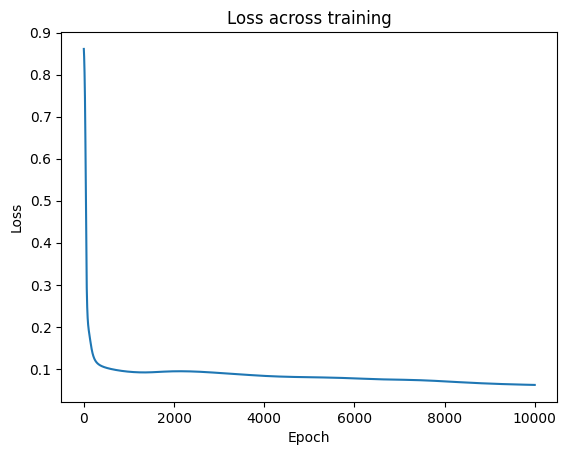

In [309]:
plt.title("Loss across training")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(trm.loss_d)

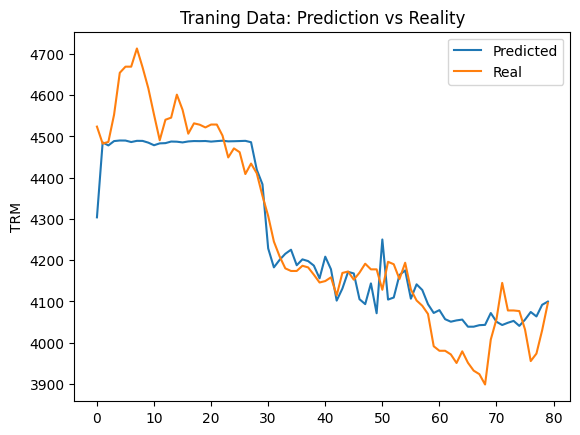

In [310]:
predicted = trm.forward(X)
predicted =predicted.reshape(predicted.shape[:2])
predicted = scalerout.inverse_transform(predicted)
real = scalerout.inverse_transform(y.reshape(y.shape[:2]))

plt.title("Traning Data: Prediction vs Reality")
plt.ylabel("TRM")
plt.plot(predicted, label="Predicted")
plt.plot(real, label="Real")
plt.legend()

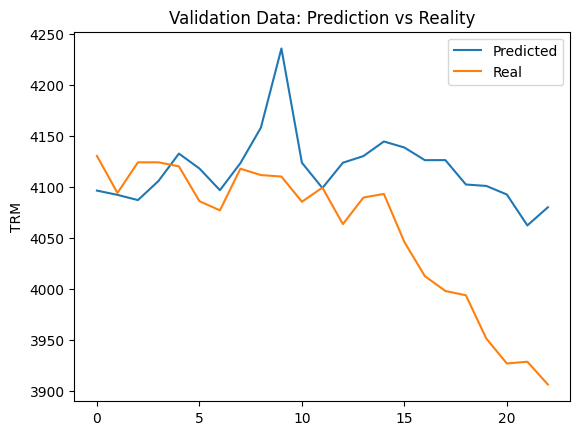

In [311]:
predicted = trm.forward(X_test)
predicted =predicted.reshape(predicted.shape[:2])
predicted = scalerout.inverse_transform(predicted)
real = scalerout.inverse_transform(y_test.reshape(y_test.shape[:2]))

plt.title("Validation Data: Prediction vs Reality")
plt.ylabel("TRM")
plt.plot(predicted, label="Predicted")
plt.plot(real, label="Real")
plt.legend()